## Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from google.colab import files, drive
from collections import namedtuple
from torch.optim import Adam, LBFGS
from torchvision import models

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Main Code

In [ ]:
# Loading and showing the images
def load_image(img_path, transform=None, max_size=400, shape=None):
    image = Image.open(img_path)

    if max_size:
        scale = max_size / max(image.size)
        size = int(scale * image.size[0]), int(scale * image.size[1])
        # image = image.resize(size, Image.ANTIALIAS)
        image = image.resize(size, Image.LANCZOS)

    if shape:
        # image = image.resize(shape, Image.ANTIALIAS)
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Content image
choice = input("Use default Image for Content?(y/n):\t")
flag = True if choice.lower()[0] == 'y' else False

if flag: content_image = load_image('/content/drive/MyDrive/Internship/Images/content1.jpeg', transform)
else:
  print("Please upload the content image:")
  uploaded = files.upload()
  content_image = load_image(list(uploaded.keys())[0], transform)

# Style image
choice = input("Use default Image for Style?(y/n):\t")
flag = True if choice.lower()[0] == 'y' else False

if flag: style_image = load_image('/content/drive/MyDrive/Internship/Images/style1.jpeg', transform, shape=[content_image.size(3), content_image.size(2)])
else:
  print("Please upload the style image:")
  uploaded = files.upload()
  style_image = load_image(list(uploaded.keys())[0], transform, shape=[content_image.size(3), content_image.size(2)])

Use default Image for Content?(y/n):	y
Use default Image for Style?(y/n):	y


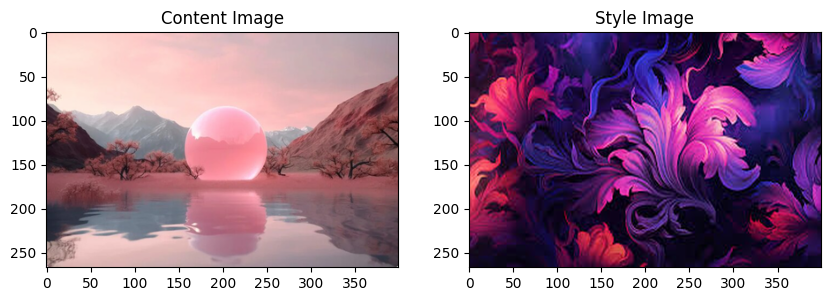

In [ ]:
def imshow(tensor, title=None, ax=None):
    image = tensor.clone().detach().cpu().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)

    if ax is None:
        plt.imshow(image)
        if title:
            plt.title(title)
        plt.pause(0.001)
    else:
        ax.imshow(image)
        if title:
            ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

imshow(content_image, 'Content Image', ax=axs[0])
imshow(style_image, 'Style Image', ax=axs[1])
plt.show()

In [ ]:
# Picking the conv layers that are used for style representation except conv4_2 which will be using for content representation

class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False, show_progress=False, use_relu=True):
        super().__init__()
        # vgg_pretrained_features = models.vgg19(pretrained=True, progress=show_progress).features
        vgg_pretrained_features = models.vgg19(weights=models.VGG19_Weights.DEFAULT, progress=show_progress).features
        if use_relu:  # use relu or as in original paper conv layers
            self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'conv4_2', 'relu5_1']
            self.offset = 1
        else:
            self.layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1']
            self.offset = 0

        self.content_feature_maps_index = 4  # conv4_2

        # all layers except conv4_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))
        self.style_feature_maps_indices.remove(4)

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        for x in range(1+self.offset):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(1+self.offset, 6+self.offset):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(6+self.offset, 11+self.offset):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(11+self.offset, 20+self.offset):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(20+self.offset, 22):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22, 29++self.offset):
            self.slice6.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        layer1_1 = x
        x = self.slice2(x)
        layer2_1 = x
        x = self.slice3(x)
        layer3_1 = x
        x = self.slice4(x)
        layer4_1 = x
        x = self.slice5(x)
        conv4_2 = x
        x = self.slice6(x)
        layer5_1 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(layer1_1, layer2_1, layer3_1, layer4_1, conv4_2, layer5_1)
        return out

In [ ]:
vgg_model = Vgg19(requires_grad=False, show_progress=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 129MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model.to(device)

Vgg19(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (slice4): Sequential(
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): R

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            'slice1': 'conv1_1',
            'slice2': 'conv2_1',
            'slice3': 'conv3_1',
            'slice4': 'conv4_1',
            'slice5': 'conv4_2',
            'slice6': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model.named_children():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

content_features = get_features(content_image, vgg_model)
style_features = get_features(style_image, vgg_model)

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
# style weights from each layer
style_weights = {
    'conv1_1': 0.2,
    'conv2_1': 0.2,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1e5
style_weight = 3e4

steps = 1000
cnt = 0

In [ ]:
# Initial input image
target = content_image.clone().requires_grad_(True).to(device)

optimizer = optim.LBFGS([target], max_iter=steps, line_search_fn='strong_wolfe')

# Boiler-plate Code
def closure():
    global cnt

    if torch.is_grad_enabled():
        optimizer.zero_grad()

    target_features = get_features(target, vgg_model)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    # Total loss
    total_loss = content_loss * content_weight + style_loss * style_weight

    # Backward pass
    total_loss.backward()

    with torch.no_grad():
        print(f'\r L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={content_loss.item():12.4f}, style loss={style_loss.item():12.4f}',end = '')
        cnt += 1

    return total_loss

optimizer.step(closure)

 L-BFGS | iteration: 1004, total loss= 146709.5625, content_loss=      0.6861, style loss=      2.6034

tensor(7190592., grad_fn=<AddBackward0>)

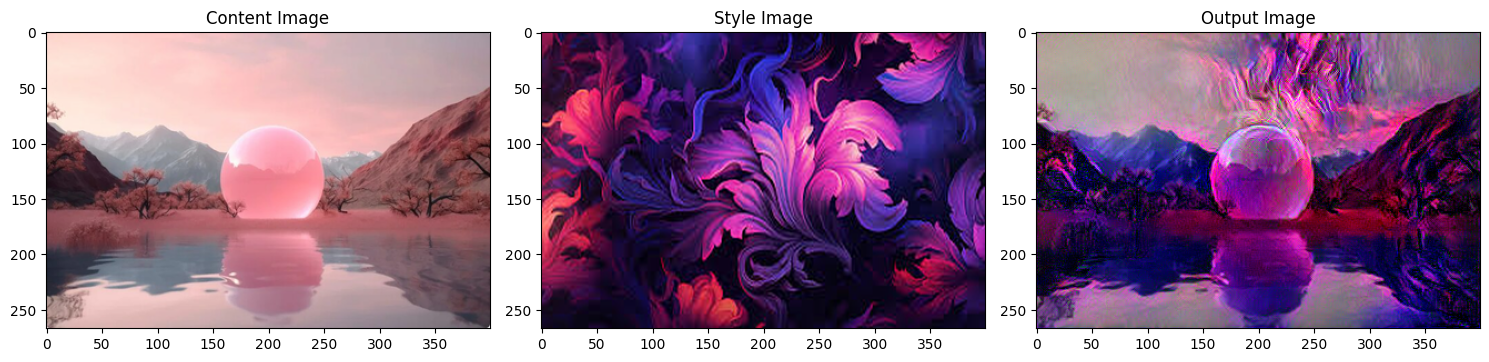

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

imshow(content_image, 'Content Image', ax=axs[0])
imshow(style_image, 'Style Image', ax=axs[1])
imshow(target, 'Output Image', ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
def save_and_download_image(the_image, location = "XYZ.jpeg"):
  image_array = the_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
  image_array = (image_array * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
  image = Image.fromarray((image_array * 255).astype(np.uint8))
  image.save(location)
  files.download(location)

In [ ]:
save_and_download_image(target, '/content/final_output.jpeg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## With other Images

In [ ]:
# Content image 2
choice = input("Use default Image for Content?(y/n):\t")
flag = True if choice.lower()[0] == 'y' else False

if flag: content_image2 = load_image('/content/drive/MyDrive/Internship/Images/content2.jpg', transform)
else:
  print("Please upload the content image:")
  uploaded = files.upload()
  content_image2 = load_image(list(uploaded.keys())[0], transform)

# Style image
choice = input("Use default Image for Style?(y/n):\t")
flag = True if choice.lower()[0] == 'y' else False

if flag: style_image2 = load_image('/content/drive/MyDrive/Internship/Images/style2.jpeg', transform, shape=[content_image2.size(3), content_image2.size(2)])
else:
  print("Please upload the style image:")
  uploaded = files.upload()
  style_image2 = load_image(list(uploaded.keys())[0], transform, shape=[content_image2.size(3), content_image2.size(2)])

Use default Image for Content?(y/n):	y
Use default Image for Style?(y/n):	y


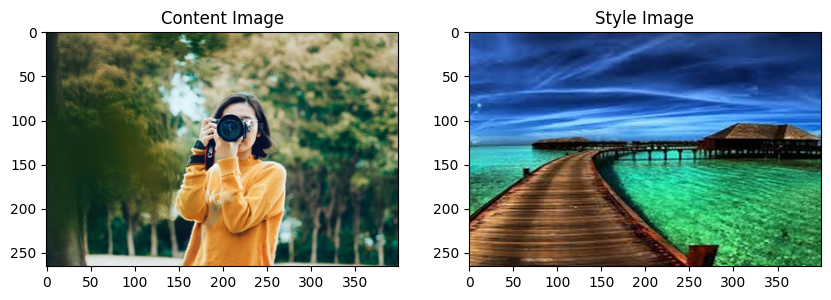

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

imshow(content_image2, 'Content Image', ax=axs[0])
imshow(style_image2, 'Style Image', ax=axs[1])

In [ ]:
vgg_model2 = Vgg19(requires_grad=False, show_progress=True)

In [ ]:
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model2.to(device2)

Vgg19(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (slice4): Sequential(
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): R

In [ ]:
content_features2 = get_features(content_image2, vgg_model2)
style_features2 = get_features(style_image2, vgg_model2)

In [ ]:
style_grams2 = {layer: gram_matrix(style_features2[layer]) for layer in style_features2}

In [ ]:
# style weights from each layer
style_weights2 = {
    'conv1_1': 0.2,
    'conv2_1': 0.2,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight2 = 1e5
style_weight2 = 3e4

steps = 1000
cnt = 0

In [ ]:
# Initial input image
target2 = content_image2.clone().requires_grad_(True).to(device2)

optimizer2 = optim.LBFGS([target2], max_iter=steps, line_search_fn='strong_wolfe')

# Boiler-plate Code
def closure():
    global cnt

    if torch.is_grad_enabled():
        optimizer2.zero_grad()

    target_features = get_features(target2, vgg_model2)

    content_loss = torch.mean((target_features['conv4_2'] - content_features2['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights2:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams2[layer]
        layer_style_loss = style_weights2[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    # Total loss
    total_loss = content_loss * content_weight2 + style_loss * style_weight2

    # Backward pass
    total_loss.backward()

    with torch.no_grad():
        print(f'\r L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={content_loss.item():12.4f}, style loss={style_loss.item():12.4f}',end = '')
        cnt += 1

    return total_loss

optimizer2.step(closure)

 L-BFGS | iteration: 1004, total loss= 129189.6406, content_loss=      0.5066, style loss=      2.6178

tensor(2706632.5000, grad_fn=<AddBackward0>)

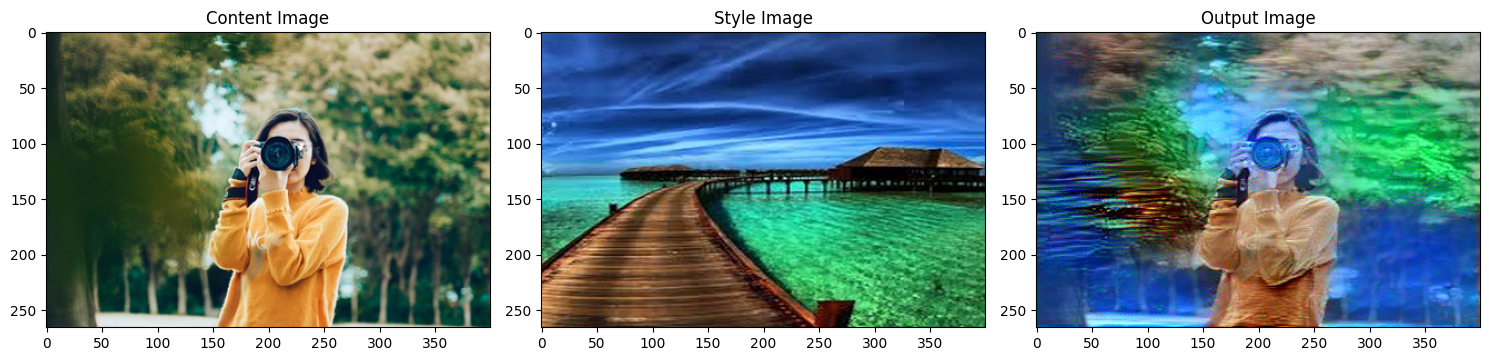

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

imshow(content_image2, 'Content Image', ax=axs[0])
imshow(style_image2, 'Style Image', ax=axs[1])
imshow(target2, 'Output Image', ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
save_and_download_image(target2, '/content/final_output2.jpeg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary: Outputs

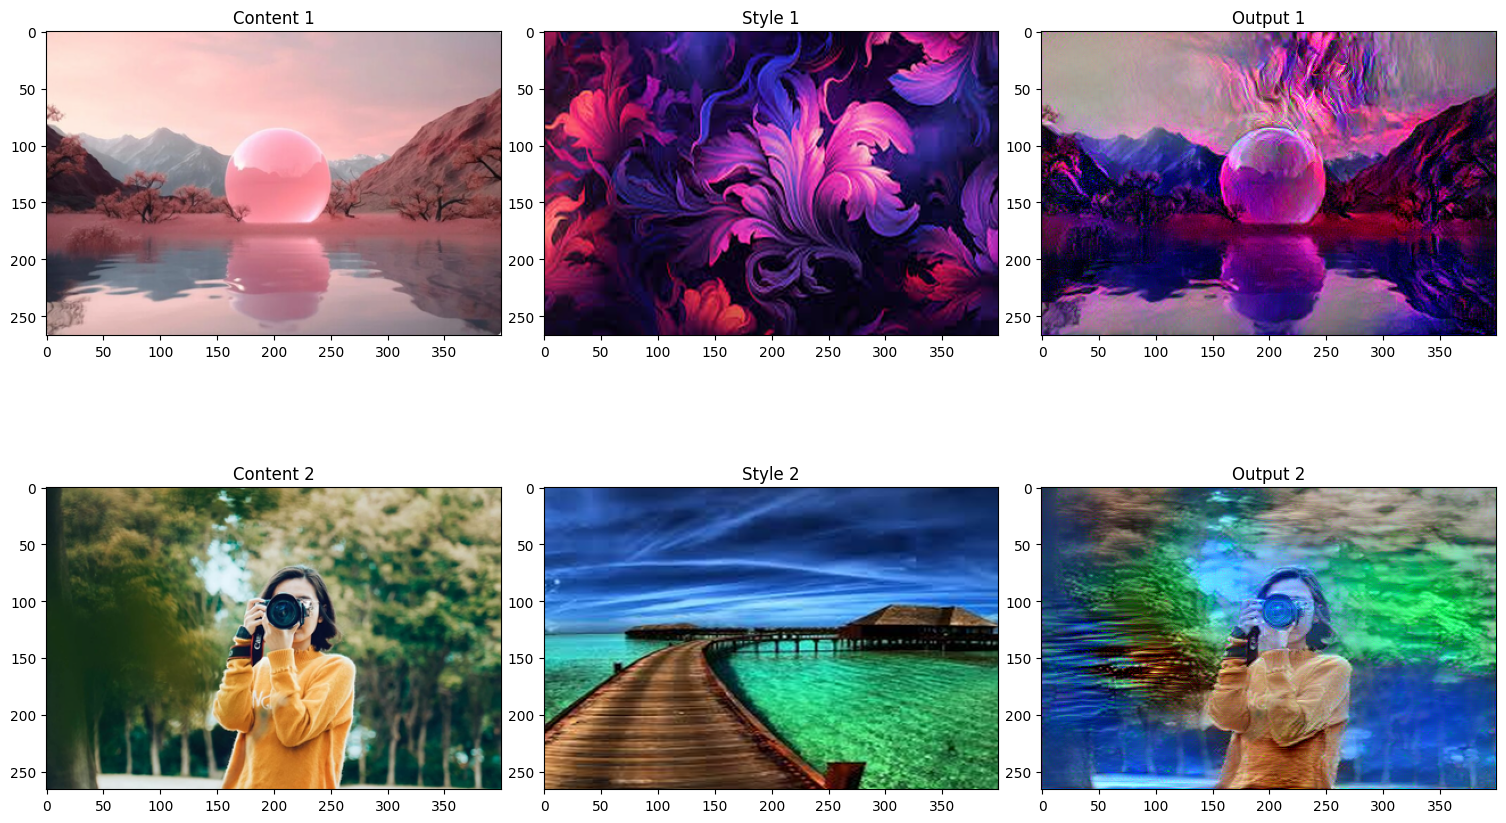

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

imshow(content_image, 'Content 1', ax=axs[0, 0])
imshow(style_image, 'Style 1', ax=axs[0, 1])
imshow(target, 'Output 1', ax=axs[0, 2])
imshow(content_image2, 'Content 2', ax=axs[1, 0])
imshow(style_image2, 'Style 2', ax=axs[1, 1])
imshow(target2, 'Output 2', ax=axs[1, 2])

plt.tight_layout(pad=0.5, h_pad=0.0, w_pad=0.5)
plt.show()